## _(3) - Segmenting Stage_

In [1]:
import glob, os, sys, yaml

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
pp = pprint.PrettyPrinter(indent=2)
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ['EXATRKX_DATA'] = os.path.abspath(os.curdir)

### _3.1 - Config File_

In [6]:
# load processing config file (trusted source)
config_path = 'LightningModules/Segmenting/configs/segment_quickstart.yaml'
config_file = os.path.join(os.curdir, config_path)
with open(config_file) as f:
    try:
        config = yaml.load(f, Loader=yaml.FullLoader) # equiv: yaml.full_load(f)
    except yaml.YAMLError as e:
        print(e)

In [7]:
config["input_dir"] = 'run_all/gnn_processed/test'

### _3.2 - Input Data_

In [8]:
# fetch all files
inputdir = config["input_dir"]
gnn_files = sorted(glob.glob(os.path.join(inputdir, "*")))

In [9]:
event_idx = 1

In [10]:
gnn_data = torch.load(gnn_files[event_idx], map_location=device)
print("Length of Data: {}".format(len(gnn_data)))

Length of Data: 11


In [11]:
gnn_data

Data(x=[171, 3], pid=[171], layers=[171], event_file='/global/cscratch1/sd/aakram/train_all/event0000095001', hid=[171], pt=[171], modulewise_true_edges=[2, 160], layerwise_true_edges=[2, 172], edge_index=[2, 808], y_pid=[808], scores=[1616])

In [12]:
gnn_data.x[:10]

tensor([[ 0.1663,  0.0097,  0.0036],
        [ 0.1663, -0.6570,  0.0022],
        [ 0.1669,  0.6956,  0.0025],
        [ 0.1669, -0.3623,  0.0018],
        [ 0.1669,  0.6956,  0.0020],
        [ 0.1669, -0.6377,  0.0019],
        [ 0.1681,  0.2853,  0.0032],
        [ 0.1681, -0.7147,  0.0033],
        [ 0.1681,  0.6187,  0.0019],
        [ 0.1723, -0.9150,  0.0009]], grad_fn=<SliceBackward0>)

In [13]:
gnn_data.event_file

'/global/cscratch1/sd/aakram/train_all/event0000095001'

In [14]:
type(gnn_data.y_pid)

torch.Tensor

In [15]:
np.unique(gnn_data.pid)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

### _3.3 - Segmentation_

### _(a) - Connected Components Labelling (CCL)_

In [16]:
import scipy.sparse as sp
import scipy.sparse.csgraph as scigraph
from torch_geometric.utils import to_scipy_sparse_matrix

In [17]:
def label_graph(input_file, edge_cut=0.5):
    
    graph = torch.load(input_file, map_location=device)
    scores = graph.scores[:graph.edge_index.shape[1]] 
    passing_edges = graph.edge_index[:, scores > edge_cut]
    sparse_edges = to_scipy_sparse_matrix(passing_edges)
    labels = scigraph.connected_components(sparse_edges)[1]
    graph.labels = torch.from_numpy(labels).type_as(passing_edges)

    return graph

In [18]:
labeled_graph = label_graph(gnn_files[event_idx], edge_cut=config["edge_cut"])

In [19]:
labeled_graph

Data(x=[171, 3], pid=[171], layers=[171], event_file='/global/cscratch1/sd/aakram/train_all/event0000095001', hid=[171], pt=[171], modulewise_true_edges=[2, 160], layerwise_true_edges=[2, 172], edge_index=[2, 808], y_pid=[808], scores=[1616], labels=[171])

In [20]:
labeled_graph.labels

tensor([0, 1, 2, 3, 2, 1, 4, 5, 6, 7, 0, 2, 1, 2, 5, 3, 1, 4, 6, 7, 2, 2, 3, 1,
        1, 0, 5, 6, 4, 7, 7, 2, 1, 0, 2, 5, 1, 3, 1, 6, 4, 7, 2, 2, 1, 1, 0, 5,
        3, 6, 4, 4, 7, 0, 1, 5, 1, 1, 3, 2, 2, 6, 4, 4, 7, 0, 2, 1, 1, 3, 2, 5,
        6, 7, 0, 4, 1, 5, 2, 2, 1, 3, 6, 4, 7, 4, 4, 2, 5, 2, 1, 0, 3, 6, 5, 2,
        2, 1, 1, 6, 0, 3, 7, 2, 5, 2, 1, 0, 3, 6, 1, 1, 5, 2, 7, 2, 1, 0, 3, 6,
        1, 5, 2, 1, 2, 7, 0, 6, 3, 1, 5, 2, 1, 2, 7, 0, 6, 3, 5, 2, 1, 1, 2, 6,
        7, 1, 3, 0, 5, 2, 2, 1, 6, 0, 3, 7, 1, 5, 2, 2, 1, 6, 0, 3, 1, 7, 5, 2,
        2, 1, 1])

In [21]:
# EDA CCL
graph = torch.load(gnn_files[event_idx], map_location=device)
scores = graph.scores[:graph.edge_index.shape[1]]
passing_edges = graph.edge_index[:, scores > 0.5]
sparse_edges = to_scipy_sparse_matrix(passing_edges)
labels = scigraph.connected_components(sparse_edges)[1]
graph.labels = torch.from_numpy(labels).type_as(passing_edges)

In [22]:
graph

Data(x=[171, 3], pid=[171], layers=[171], event_file='/global/cscratch1/sd/aakram/train_all/event0000095001', hid=[171], pt=[171], modulewise_true_edges=[2, 160], layerwise_true_edges=[2, 172], edge_index=[2, 808], y_pid=[808], scores=[1616], labels=[171])

In [23]:
graph.labels

tensor([0, 1, 2, 3, 2, 1, 4, 5, 6, 7, 0, 2, 1, 2, 5, 3, 1, 4, 6, 7, 2, 2, 3, 1,
        1, 0, 5, 6, 4, 7, 7, 2, 1, 0, 2, 5, 1, 3, 1, 6, 4, 7, 2, 2, 1, 1, 0, 5,
        3, 6, 4, 4, 7, 0, 1, 5, 1, 1, 3, 2, 2, 6, 4, 4, 7, 0, 2, 1, 1, 3, 2, 5,
        6, 7, 0, 4, 1, 5, 2, 2, 1, 3, 6, 4, 7, 4, 4, 2, 5, 2, 1, 0, 3, 6, 5, 2,
        2, 1, 1, 6, 0, 3, 7, 2, 5, 2, 1, 0, 3, 6, 1, 1, 5, 2, 7, 2, 1, 0, 3, 6,
        1, 5, 2, 1, 2, 7, 0, 6, 3, 1, 5, 2, 1, 2, 7, 0, 6, 3, 5, 2, 1, 1, 2, 6,
        7, 1, 3, 0, 5, 2, 2, 1, 6, 0, 3, 7, 1, 5, 2, 2, 1, 6, 0, 3, 1, 7, 5, 2,
        2, 1, 1])

In [24]:
labeled_graph.labels == graph.labels

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [25]:
# unique particles
np.unique(labeled_graph.pid)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [26]:
# unique tracks (CC)
np.unique(labeled_graph.labels)

array([0, 1, 2, 3, 4, 5, 6, 7])

### _Plotting the CC_

In [27]:
from src.drawing import detector_layout
from src.utils_math import polar_to_cartesian

In [28]:
# event id from the file itself
e_id = int(labeled_graph.event_file[-10:])

# pids for true_track, unique labels for reco_tracks
true_track, reco_track = labeled_graph, labeled_graph

In [29]:
r, phi, ir = labeled_graph.x.T
ir = ir.detach().numpy()*100
x, y = polar_to_cartesian(r.detach().numpy(), phi.detach().numpy())

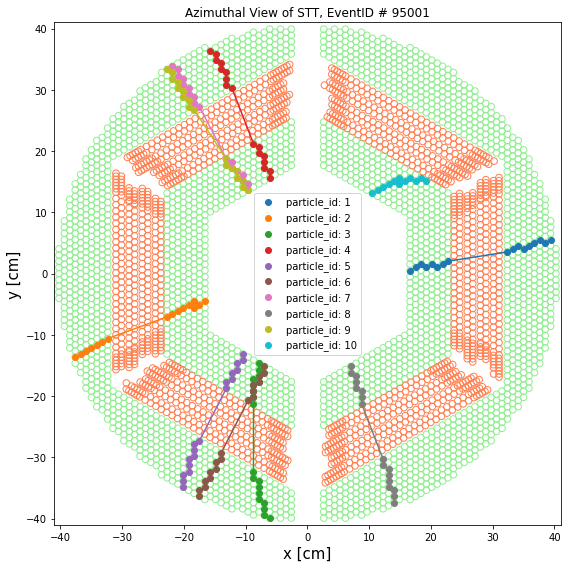

In [30]:
# plot true event
fig, ax = detector_layout(figsize=(8,8))
p_ids = np.unique(true_track.pid)

for pid in p_ids:
    idx = true_track.pid == pid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], label='particle_id: {}'.format(int(pid)))

ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("true_track.png")

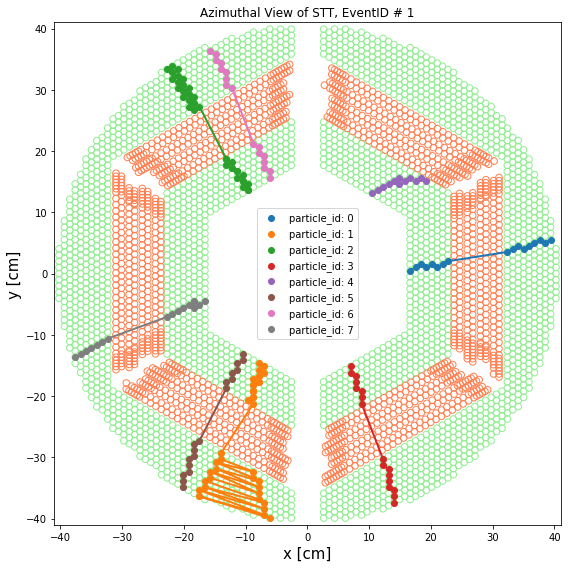

In [31]:
# plot reco event from CCL
fig, ax = detector_layout(figsize=(8,8))
t_ids = np.unique(reco_track.labels)

# here, (x,y,ir) comes from the true event,
# but idx comes from reco event from CCL

for tid in t_ids:
    idx = reco_track.labels == tid
    ax.plot(x[idx], y[idx], '-', linewidth=2)
    ax.scatter(x[idx], y[idx], label='particle_id: {}'.format(tid))
    
ax.set_title('Azimuthal View of STT, EventID # {}'.format(event_idx))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("reco_track.png")

### _(b) - DBSCAN Labelling_

In [32]:
from sklearn.cluster import DBSCAN
from scipy.sparse import csr_matrix

In [33]:
# from LightningModules.Segmenting import label_graph_dbscan

In [34]:
input_file = gnn_files[event_idx]
output_file = os.path.join('run/seg_processed/', os.path.split(input_file)[-1])

In [35]:
os.path.split(input_file)

('run_all/gnn_processed/test', '5001')

In [36]:
input_file

'run_all/gnn_processed/test/5001'

In [37]:
output_file

'run/seg_processed/5001'

In [38]:
# gnn_processed graph
graph = torch.load(gnn_files[event_idx], map_location=device)

In [39]:
edge_cut = 0.
epsilon = 0.25
min_samples=2
evtid = int(os.path.basename(input_file))

In [40]:
scores = graph.scores[:graph.edge_index.shape[1]]  # score has twice the size of edge_index (due to flip(0))
senders = graph.edge_index[0]
receivers = graph.edge_index[1]
hit_id = graph.hid

In [41]:
n_nodes = hit_id.shape[0]
if edge_cut > 0:
    cuts = score > edge_cut
    score, senders, receivers = score[cuts], senders[cuts], receivers[cuts]

In [42]:
# prepare the DBSCAN input, the adjancy matrix with its value being the edge socre.
e_csr = sp.csr_matrix((scores, (senders, receivers)),
                      shape=(n_nodes, n_nodes),
                      dtype=np.float32)

In [43]:
e_csr.data[:10]

array([9.9992204e-01, 8.0207006e-05, 2.0691472e-04, 9.9992442e-01,
       8.0039368e-05, 7.9207050e-05, 8.7915330e-05, 7.8574893e-05,
       5.2932763e-01, 8.6728573e-01], dtype=float32)

In [44]:
# rescale the duplicated edges
e_csr.data[e_csr.data > 1] = e_csr.data[e_csr.data > 1] / 2.

In [45]:
e_csr.data[:10]

array([9.9992204e-01, 8.0207006e-05, 2.0691472e-04, 9.9992442e-01,
       8.0039368e-05, 7.9207050e-05, 8.7915330e-05, 7.8574893e-05,
       5.2932763e-01, 8.6728573e-01], dtype=float32)

In [46]:
# invert to treat score as an inverse distance
e_csr.data = 1 - e_csr.data

In [47]:
e_csr.data[:10]

array([7.7962875e-05, 9.9991977e-01, 9.9979311e-01, 7.5578690e-05,
       9.9991995e-01, 9.9992079e-01, 9.9991208e-01, 9.9992144e-01,
       4.7067237e-01, 1.3271427e-01], dtype=float32)

In [48]:
# make it symmetric
e_csr_bi = sp.coo_matrix(
    (np.hstack([e_csr.tocoo().data, e_csr.tocoo().data]),
     np.hstack([np.vstack([e_csr.tocoo().row, e_csr.tocoo().col]),
                np.vstack([e_csr.tocoo().col, e_csr.tocoo().row])]
               )
     )
)

In [49]:
e_csr_bi.data

array([7.7962875e-05, 9.9991977e-01, 9.9979311e-01, ..., 9.9990970e-01,
       9.9991894e-01, 9.9990076e-01], dtype=float32)

In [50]:
# DBSCAN get track candidates
clustering = DBSCAN(
    eps=epsilon, metric='precomputed',
    min_samples=min_samples).fit_predict(e_csr_bi)

/shared/adeel/anaconda3/envs/exatrkx-cpu/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


In [51]:
clustering

array([ 0,  1,  2,  3, -1,  4,  5,  6,  7,  8,  0,  9,  1,  2,  6,  3,  4,
        5,  7,  8,  2,  9,  3,  4, 10,  0,  6,  7,  5,  8,  8,  9, 10,  0,
        2,  6, 10,  3,  4,  7,  5,  8,  9,  2, 10,  4,  0,  6,  3,  7,  5,
        5,  8,  0, 11,  6, 12, 12,  3,  2,  9,  7,  5,  5,  8,  0,  9, 11,
       12,  3,  2,  6,  7,  8,  0,  5, 12,  6,  2,  9, 11,  3,  7,  5,  8,
        5,  5,  2,  6,  9, 12,  0,  3,  7,  6,  2,  9, 12, 11,  7,  0,  3,
        8,  2,  6,  9, 12,  0,  3,  7, 11, 11,  6,  2,  8,  9, 12,  0,  3,
        7, 11,  6,  2, 12,  9,  8,  0,  7,  3, 11,  6,  2, 12,  9,  8,  0,
        7,  3,  6,  2, 12, 11,  9,  7,  8, 11,  3,  0,  6,  2,  9, 12,  7,
        0,  3,  8, 11,  6,  2,  9, 12,  7,  0,  3, 11,  8,  6,  2,  9, 12,
       11])

In [52]:
track_labels = np.vstack(
            [np.unique(e_csr_bi.tocoo().row),
             clustering[np.unique(e_csr_bi.tocoo().row)]])

In [53]:
np.unique(e_csr_bi.tocoo().row)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170], dtype=int32)

In [54]:
clustering[np.unique(e_csr_bi.tocoo().row)]

array([ 0,  1,  2,  3, -1,  4,  5,  6,  7,  8,  0,  9,  1,  2,  6,  3,  4,
        5,  7,  8,  2,  9,  3,  4, 10,  0,  6,  7,  5,  8,  8,  9, 10,  0,
        2,  6, 10,  3,  4,  7,  5,  8,  9,  2, 10,  4,  0,  6,  3,  7,  5,
        5,  8,  0, 11,  6, 12, 12,  3,  2,  9,  7,  5,  5,  8,  0,  9, 11,
       12,  3,  2,  6,  7,  8,  0,  5, 12,  6,  2,  9, 11,  3,  7,  5,  8,
        5,  5,  2,  6,  9, 12,  0,  3,  7,  6,  2,  9, 12, 11,  7,  0,  3,
        8,  2,  6,  9, 12,  0,  3,  7, 11, 11,  6,  2,  8,  9, 12,  0,  3,
        7, 11,  6,  2, 12,  9,  8,  0,  7,  3, 11,  6,  2, 12,  9,  8,  0,
        7,  3,  6,  2, 12, 11,  9,  7,  8, 11,  3,  0,  6,  2,  9, 12,  7,
        0,  3,  8, 11,  6,  2,  9, 12,  7,  0,  3, 11,  8,  6,  2,  9, 12,
       11])

In [55]:
# similar to label_graph_ccl() >> graph.labels = labels
graph.labels = clustering[np.unique(e_csr_bi.tocoo().row)]

In [56]:
track_labels

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170],
       [  0,   1,   2,   3,  -1,

In [57]:
graph.track_lables1 = torch.from_numpy(track_labels)

In [58]:
graph.track_lables1

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
         154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
         168, 169, 170],
        [  0,   1,   2,   3

In [59]:
track_labels = pd.DataFrame(track_labels.T)
track_labels.columns = ["hit_id", "track_id"]

new_hit_id = np.apply_along_axis(
    lambda x: hit_id[x], 0, track_labels.hit_id.values)

predicted_tracks = pd.DataFrame.from_dict(
    {"hit_id": new_hit_id, "track_id": track_labels.track_id})

In [60]:
predicted_tracks

,hit_id,track_id
0,222,0
1,171,1
2,16,2
3,42,3
4,67,-1
...,...,...
166,145,6
167,92,2
168,41,9
169,119,12


In [61]:
graph.track_lables2 = torch.Tensor(predicted_tracks.values)

In [62]:
graph.track_lables2

tensor([[222.,   0.],
        [171.,   1.],
        [ 16.,   2.],
        [ 42.,   3.],
        [ 67.,  -1.],
        [ 93.,   4.],
        [  1.,   5.],
        [120.,   6.],
        [146.,   7.],
        [198.,   8.],
        [223.,   0.],
        [ 68.,   9.],
        [172.,   1.],
        [ 17.,   2.],
        [121.,   6.],
        [ 43.,   3.],
        [ 94.,   4.],
        [  2.,   5.],
        [147.,   7.],
        [199.,   8.],
        [ 18.,   2.],
        [ 69.,   9.],
        [ 44.,   3.],
        [ 95.,   4.],
        [173.,  10.],
        [224.,   0.],
        [122.,   6.],
        [148.,   7.],
        [  3.,   5.],
        [200.,   8.],
        [201.,   8.],
        [ 70.,   9.],
        [174.,  10.],
        [225.,   0.],
        [ 19.,   2.],
        [123.,   6.],
        [175.,  10.],
        [ 45.,   3.],
        [ 96.,   4.],
        [149.,   7.],
        [  4.,   5.],
        [202.,   8.],
        [ 71.,   9.],
        [ 20.,   2.],
        [176.,  10.],
        [ 

In [63]:
graph

Data(x=[171, 3], pid=[171], layers=[171], event_file='/global/cscratch1/sd/aakram/train_all/event0000095001', hid=[171], pt=[171], modulewise_true_edges=[2, 160], layerwise_true_edges=[2, 172], edge_index=[2, 808], y_pid=[808], scores=[1616], labels=[171], track_lables1=[2, 171], track_lables2=[171, 2])

In [64]:
labeled_graph = graph

In [65]:
# event id from the file itself
e_id = int(labeled_graph.event_file[-10:])

# pids for true_track, unique labels for reco_tracks
true_track, reco_track = labeled_graph, labeled_graph

In [66]:
r, phi, ir = labeled_graph.x.T
ir = ir.detach().numpy()*100
x, y = polar_to_cartesian(r.detach().numpy(), phi.detach().numpy())

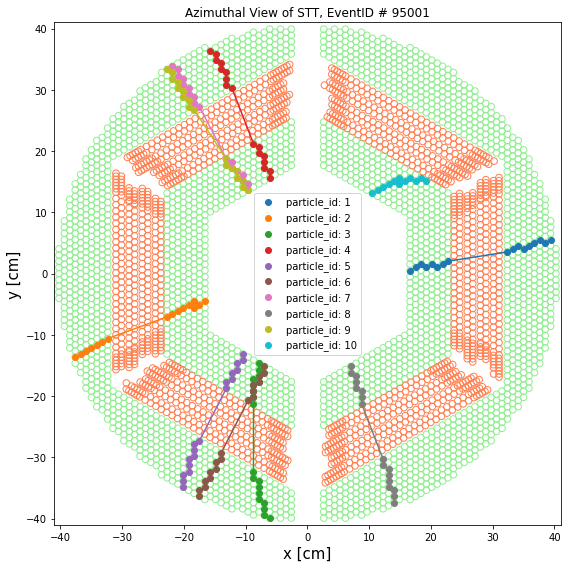

In [67]:
# plot true event
fig, ax = detector_layout(figsize=(8,8))
p_ids = np.unique(true_track.pid)

for pid in p_ids:
    idx = true_track.pid == pid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], label='particle_id: {}'.format(int(pid)))

ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("true_track.png")

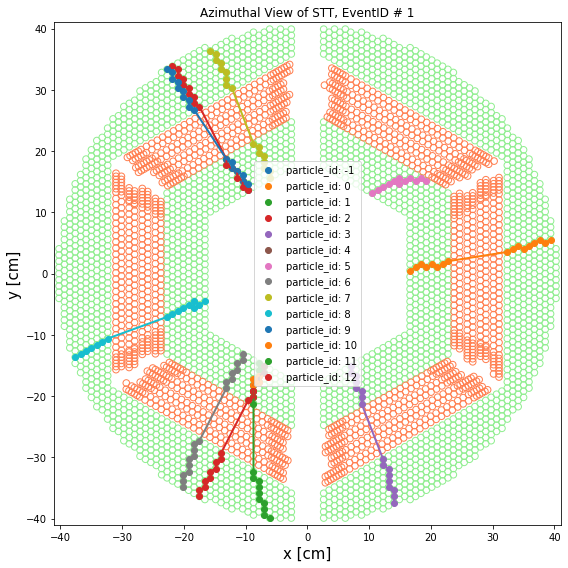

In [68]:
# plot reco event from CCL
fig, ax = detector_layout(figsize=(8,8))
t_ids = np.unique(reco_track.labels)

# here, (x,y,ir) comes from the true event,
# but idx comes from reco event from CCL

for tid in t_ids:
    idx = reco_track.labels == tid
    ax.plot(x[idx], y[idx], '-', linewidth=2)
    ax.scatter(x[idx], y[idx], label='particle_id: {}'.format(tid))
    
ax.set_title('Azimuthal View of STT, EventID # {}'.format(event_idx))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("reco_track.png")

### _(c) - Wrangler Labelling_

In [69]:
import networkx as nx
from torch_geometric.utils import to_networkx
from LightningModules.Segmenting import get_tracks

In [70]:
G = to_networkx(graph, node_attrs=['x'], edge_attrs=['scores', 'y_pid'])

In [71]:
G.nodes[0]['x'][2]

0.0035587300080806017

In [72]:
nx_graph = get_tracks(G, th=0.1, th_re=0.8, feature_name='scores', with_fit=False)

In [73]:
nx_graph

In [74]:
from src.drawing import detector_layout
from src.utils_math import polar_to_cartesian

In [75]:
# from https://github.com/exatrkx/exatrkx-neurips19/blob/master/gnn-tracking/heptrkx/nx_graph/utils_plot.py
def get_pos(Gp):
    pos = {}
    for node in Gp.nodes():
        # r, phi, z = Gp.node[node]['pos'][:3]
        r, phi = G.nodes[node]['x'][:2]
        
        theta = phi * np.pi
        x = r * np.cos(theta)*100
        y = r * np.sin(theta)*100

        pos[node] = np.array([x, y])
    return pos

def plot_networkx(G, ax=None, i=0, only_true=False):
    """G is networkx graph,
    node feature: {'pos': [r, phi, z]}
    edge feature: {"solution": []}
    """
    if ax is None:
        fig, ax = plt.subplots()

    n_edges = len(G.edges())
    edge_colors = [0.]*n_edges
    true_edges = []
    for iedge, edge in enumerate(G.edges(data=True)):
        if int(edge[2]['y_pid']) == 1:
            edge_colors[iedge] = 'r'
            true_edges.append((edge[0], edge[1]))
        else:
            edge_colors[iedge] = 'grey'

    Gp = nx.edge_subgraph(G, true_edges) if only_true else G
    edge_colors = ['k']*len(true_edges) if only_true else edge_colors 

    pos = get_pos(Gp)

    nx.draw_networkx(Gp, pos, arrows=False, with_labels=False, ax=ax, 
                     node_color='#A0CBE2', edge_color=edge_colors,
                     width=3, node_size=10, label='tracks {}'.format(i))
    
    # plt.savefig("Graph.png", format="PNG")

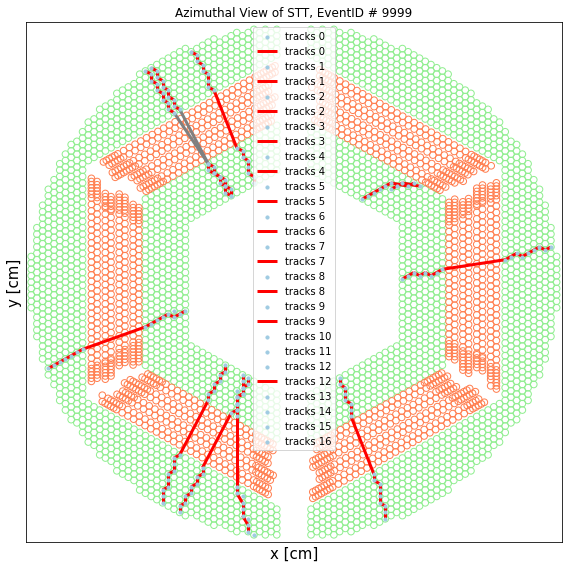

In [76]:
# plot reco event from CCL
fig, ax = detector_layout(figsize=(8,8))

for i, graph in enumerate(nx_graph):
    plot_networkx(graph, ax, i)

ax.set_title('Azimuthal View of STT, EventID # {}'.format(9999))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("reco_track.png")

- Convert _NetworkX_ to _PyG_ Graph

In [77]:
from torch_geometric.utils.convert import from_networkx

In [78]:
pyg_graph = [from_networkx(graph) for graph in nx_graph]

In [79]:
pyg_graph

[Data(x=[17, 3], edge_index=[2, 16], scores=[16], y_pid=[16]),
 Data(x=[15, 3], edge_index=[2, 14], scores=[14], y_pid=[14]),
 Data(x=[18, 3], edge_index=[2, 17], scores=[17], y_pid=[17]),
 Data(x=[17, 3], edge_index=[2, 16], scores=[16], y_pid=[16]),
 Data(x=[18, 3], edge_index=[2, 17], scores=[17], y_pid=[17]),
 Data(x=[18, 3], edge_index=[2, 17], scores=[17], y_pid=[17]),
 Data(x=[8, 3], edge_index=[2, 7], scores=[7], y_pid=[7]),
 Data(x=[18, 3], edge_index=[2, 17], scores=[17], y_pid=[17]),
 Data(x=[17, 3], edge_index=[2, 16], scores=[16], y_pid=[16]),
 Data(x=[15, 3], edge_index=[2, 14], scores=[14], y_pid=[14]),
 Data(x=[1, 3], edge_index=[2, 0]),
 Data(x=[1, 3], edge_index=[2, 0]),
 Data(x=[4, 3], edge_index=[2, 3], scores=[3], y_pid=[3]),
 Data(x=[1, 3], edge_index=[2, 0]),
 Data(x=[1, 3], edge_index=[2, 0]),
 Data(x=[1, 3], edge_index=[2, 0]),
 Data(x=[1, 3], edge_index=[2, 0])]

In [80]:
pyg_graph[0].edge_index

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16],
        [ 4,  3,  5,  8,  6,  7,  9, 10, 11, 13, 12, 15, 14,  1, 16,  2]])

In [81]:
pyg_graph[0].scores

tensor([0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999,
        0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999])

In [82]:
pyg_graph[0].y_pid

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])

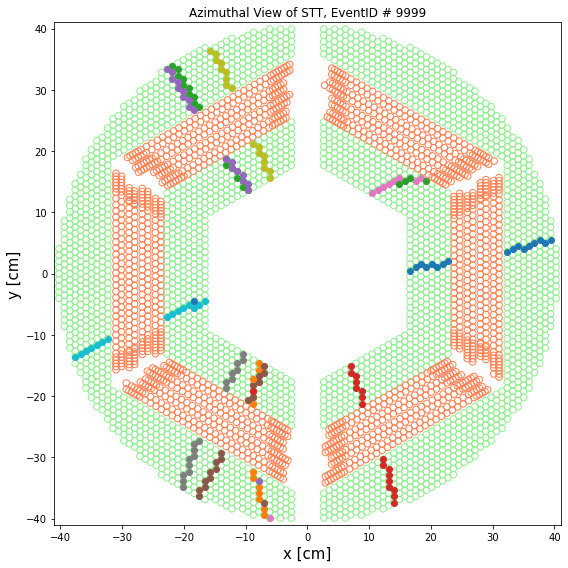

In [83]:
# plot reco event from CCL
fig, ax = detector_layout(figsize=(8,8))
#t_ids = np.unique(reco_track.track_id)

# here, (x,y,ir) comes from the true event,
# but idx comes from reco event from CCL

for graph in nx_graph:
    pyg_graph = from_networkx(graph)
    r, phi, ir = pyg_graph.x.T
    ir = ir.detach().numpy()*100
    x, y = polar_to_cartesian(r.detach().numpy(), phi.detach().numpy())
    
    ax.scatter(x, y)
    
    #idx = reco_track.track_id == tid
    #ax.plot(x[idx], y[idx], '-', linewidth=2)
    #ax.scatter(x[idx], y[idx], label='particle_id: {}'.format(tid))
    
ax.set_title('Azimuthal View of STT, EventID # {}'.format(9999))
# ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("reco_track.png")